In [1]:
import wandb

api = wandb.Api()
entity, project = "sayakpaul", "keras-xla-benchmarks"  
runs = api.runs(entity + "/" + project) 
print(f"Total runs: {len(runs)}")

Total runs: 438


In [2]:
from model_mapping import MODEL_NAME_MAPPING

all_variants = [
    variant for k in MODEL_NAME_MAPPING for variant in MODEL_NAME_MAPPING[k]
]
all_variants

['yolo_v8_m_pascalvoc', 'retinanet_resnet50_pascalvoc']

In [3]:
import pandas as pd

resolutions = []
accelerators = []

model_families = []
model_variants = []
xla_status = []

flops = []
params = []
throughputs = []

for run in runs:
    run_config = run.config
    run_summary = run.summary._json_dict

    if (
        all_variants[0] in run_config["variant"]
        or all_variants[1] in run_config["variant"]
    ):
        model_families.append(run_config["family"])
        model_variants.append(run_config["variant"])
        resolutions.append(run_config["resolution"])
        xla_status.append(run_config["xla"])

        accelerator_name = run.name.split("@")[-1].split("-")[1]
        accelerators.append(accelerator_name)

        flops.append(run_summary["FLOPs (giga)"])
        params.append(run_summary["Num parameters (million)"])
        throughputs.append(run_summary["Throughput (samples/sec)"])

viz_df = pd.DataFrame(
    {
        "model_family": model_families,
        "model_variant": model_variants,
        "resolution": resolutions,
        "xla": xla_status,
        "accelerator": accelerators,
        "flop (giga)": flops,
        "params (million)": params,
        "throughput (samples/sec)": throughputs,
    }
)
viz_df.head()

,model_family,model_variant,resolution,xla,accelerator,flop (giga),params (million),throughput (samples/sec)
0,RetinaNet,retinanet_resnet50_pascalvoc,640,True,a100,72.82,35.6,266.45
1,RetinaNet,retinanet_resnet50_pascalvoc,640,False,a100,72.82,35.6,34.93
2,RetinaNet,retinanet_resnet50_pascalvoc,320,True,a100,18.22,35.6,577.33
3,RetinaNet,retinanet_resnet50_pascalvoc,320,False,a100,18.22,35.6,35.18
4,YOLOV8,yolo_v8_m_pascalvoc,640,True,a100,39.42,25.9,417.84


In [9]:
def plot_topk_per_accelerator(
    accelerator="a100", topk=10, resolution=320, xla_status=True
):
    filtered_df = viz_df[viz_df["accelerator"] == accelerator]
    subset_df = filtered_df.query(f"resolution == {resolution} and xla == {xla_status}")
    topk_df = subset_df.nlargest(topk, ["throughput (samples/sec)"])
    return topk_df

In [10]:
# Adapted from
# https://github.com/nlp-with-transformers/notebooks/blob/main/08_model-compression.ipynb

import matplotlib.pyplot as plt


def plot_metrics(df, savefig=False):
    for model_variant in df["model_variant"]:
        filtered = df.query(f"model_variant == '{model_variant}'")
        plt.scatter(
            filtered["flop (giga)"],
            filtered["throughput (samples/sec)"],
            alpha=0.5,
            s=filtered["params (million)"] * 5,
            label=model_variant,
            marker="o",
        )

    legend = plt.legend(bbox_to_anchor=(1, 1))
    for handle in legend.legendHandles:
        handle.set_sizes([20])

    plt.ylabel("Throughput (samples/sec)", fontsize=14)
    plt.xlabel("FLOPS (giga)", fontsize=14)

    accelerator_name = df["accelerator"].unique()[0]
    resolution = df["resolution"].unique()[0]
    xla_status = df["xla"].unique()[0]
    plt.title(
        f"Accelerator: {accelerator_name}, Resolution: {resolution}, XLA: {xla_status}",
        fontsize=14,
    )
    if not savefig:
        plt.show()
    else:
        plot_name = f"{accelerator_name}_{resolution}_{xla_status}.png"
        plt.savefig(plot_name, dpi=300, bbox_inches="tight")

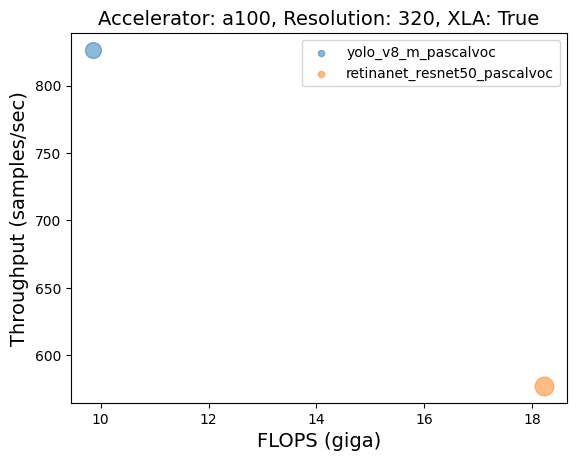

In [11]:
a100_df = plot_topk_per_accelerator("a100")
plot_metrics(a100_df)

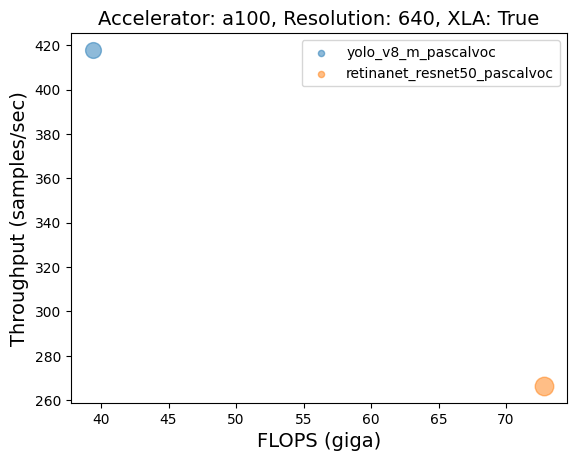

In [12]:
a100_res_640_df = plot_topk_per_accelerator("a100", resolution=640)
plot_metrics(a100_res_640_df)

In [13]:
grouped = viz_df.groupby(["resolution", "accelerator"])[
    "throughput (samples/sec)"
].idxmax()
result = viz_df.loc[grouped, viz_df.columns]
result

,model_family,model_variant,resolution,xla,accelerator,flop (giga),params (million),throughput (samples/sec)
6,YOLOV8,yolo_v8_m_pascalvoc,320,True,a100,9.86,25.9,826.40
14,YOLOV8,yolo_v8_m_pascalvoc,320,True,t4,9.86,25.9,174.76
22,YOLOV8,yolo_v8_m_pascalvoc,320,True,v100,9.86,25.9,450.19
4,YOLOV8,yolo_v8_m_pascalvoc,640,True,a100,39.42,25.9,417.84
12,YOLOV8,yolo_v8_m_pascalvoc,640,True,t4,39.42,25.9,54.61
20,YOLOV8,yolo_v8_m_pascalvoc,640,True,v100,39.42,25.9,171.12
